In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import astropy as ap
import healpy as hp
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime
import seaborn as sns

from importlib import reload

import sys, os
sys.path.append('/home/apizzuto/Nova/scripts/')
import plotting

import histlite as hl
import csky as cy

from glob import glob
mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots_nb.mplstyle')

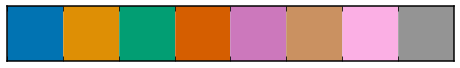

In [3]:
palette = sns.color_palette("colorblind", 8)
sns.palplot(palette)

In [4]:
elias_novae = pd.read_csv('/home/apizzuto/Nova/source_list/nova_stats_from_elias_reformatted.csv')

In [86]:
# elias_novae = elias_novae[['Nova', 'Discovery date/eruption start (t0)', 'Date of optical peak',
#        'Tmax – t0', 'RA', 'Dec',
#        'Average Flux (10^-7 ph/s/cm^2)', 'Average Flux uncertainty',
#        'Spectral index', 'Spectral Index uncertainty',
#        'gamma_start', 'gamma_end']]

In [7]:
elias_novae = elias_novae[['Nova', 'Date of optical peak',
       'RA', 'Dec',
       'Average Flux (10^-7 ph/s/cm^2)',
       'Spectral index',
       'gamma_start', 'gamma_end']]

In [8]:
elias_novae

,Nova,Date of optical peak,RA,Dec,Average Flux (10^-7 ph/s/cm^2),Spectral index,gamma_start,gamma_end
0,YZ Ret,2020-07-10,58:29.5,-54:46:41.20,2.8,1.59,2017-07-10,2017-07-24
1,V1707 Sco,2019-09-16,37:09.6,-35:10:21.10,2.3,2.00,2019-09-15,2019-09-18
2,V392 Per,2018-04-29.5,43:21.4,21:52.8,2.2,2.00,2018-04-30,2018-05-08
3,V906 Car,2018-03-16.88,36:13.7,-59:35:54.90,12.2,2.04,2018-04-08,2018-05-01
4,V357 Mus,2018-01-11,26:15.2,-65:31:23.30,1.3,2.20,2018-01-11,2018-02-07
5,V549 Vel,2017-10-03,50:29.6,-47:45:28.56,0.4,1.80,2017-10-11,2017-11-13
6,V5856 Sgr,2016-11-09,20:52.1,-28:22:13.52,4.6,2.11,2016-11-08,2016-11-23
7,V5855 Sgr,2016-10-24.8,10:28.3,-27:29:59,3.0,2.26,2016-10-25,2016-11-20
8,V407 Lup,2019-09-25.4,29:01.8,-44:49:40.89,1.6,2.20,2016-09-26,2016-09-29
9,V5668 Sgr,2015-03-21,18::36:56.87,-28:55:39.30,1.1,2.42,2015-03-24,2015-05-16


In [89]:
def clean_time_str(t):
    if not '.' in t:
        tmp = Time(t, scale='utc', format='iso').mjd
    else:
        date, frac = t.split('.')
        frac = '.' + frac
        frac = float(frac)
        mjd_date = Time(date, format='iso', scale='utc').mjd
        tmp = Time(mjd_date + frac, scale='utc', format='mjd').mjd
    return tmp

In [90]:
elias_novae['Date of optical peak'] = elias_novae['Date of optical peak'].apply(clean_time_str)
elias_novae['gamma_start'] = elias_novae['gamma_start'].apply(clean_time_str)
elias_novae['gamma_end'] = elias_novae['gamma_end'].apply(clean_time_str)

In [91]:
elias_novae.head()

,Nova,Date of optical peak,RA,Dec,Average Flux (10^-7 ph/s/cm^2),Spectral index,gamma_start,gamma_end
0,YZ Ret,59040.00,58:29.5,-54:46:41.20,2.8,1.59,57944.0,57958.0
1,V1707 Sco,58742.00,37:09.6,-35:10:21.10,2.3,2.00,58741.0,58744.0
2,V392 Per,58237.50,43:21.4,21:52.8,2.2,2.00,58238.0,58246.0
3,V906 Car,58193.88,36:13.7,-59:35:54.90,12.2,2.04,58216.0,58239.0
4,V357 Mus,58129.00,26:15.2,-65:31:23.30,1.3,2.20,58129.0,58156.0


In [92]:
old_master = pd.read_pickle('/home/apizzuto/Nova/master_nova_dataframe.pkl')

In [94]:
comp_dict = {'Name': [],
                'old_gam_start': [],
                'old_gam_stop': [],
                'new_gam_start': [],
                'new_gam_stop': []}

for ii, nov in elias_novae.iterrows():
    if  len(old_master['Name'][old_master['Name'] == nov['Nova']]) == 1:
        comp_dict['Name'].append(nov['Nova'])
        comp_dict['old_gam_start'].append(old_master['gamma_start'][old_master['Name'] == nov['Nova']].values[0].mjd)
        comp_dict['old_gam_stop'].append(old_master['gamma_stop'][old_master['Name'] == nov['Nova']].values[0].mjd)
        comp_dict['new_gam_start'].append(nov['gamma_start'])
        comp_dict['new_gam_stop'].append(nov['gamma_end'])
for k in comp_dict.keys():
    comp_dict[k] = np.asarray(comp_dict[k])

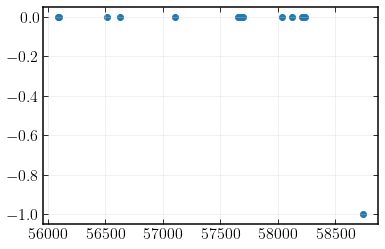

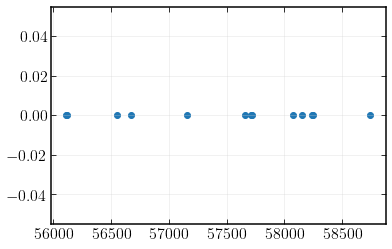

In [96]:
plt.scatter(comp_dict['old_gam_start'], comp_dict['old_gam_start'] - comp_dict['new_gam_start'])
plt.show()

plt.scatter(comp_dict['old_gam_stop'], comp_dict['old_gam_stop'] - comp_dict['new_gam_stop'])
plt.show()

In [49]:
df = pd.read_pickle('../master_nova_dataframe.pkl')

In [50]:
def clean_mag_col(p):
    if type(p) == str:
        if '(I)' in p:
            p = p.split(' (I)')[0]
        p = float(p)
    else:
        p = float(p)
    return p

In [51]:
df['Peak'] = df['Peak'].apply(clean_mag_col)

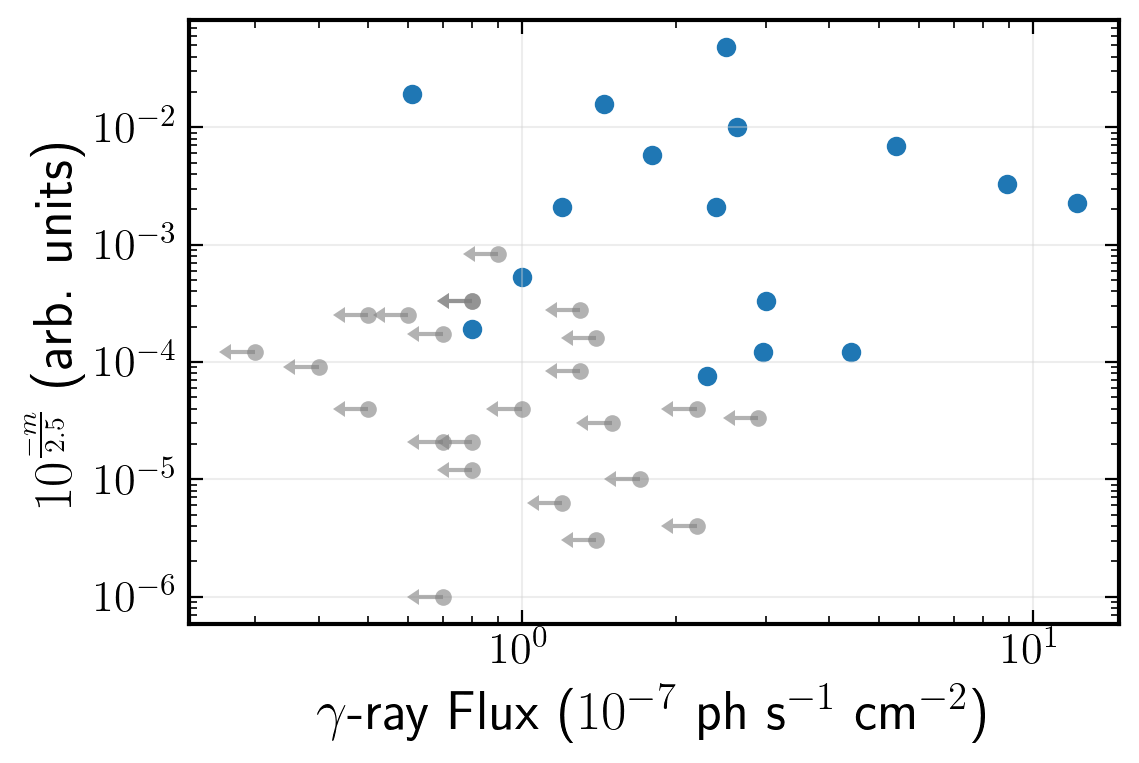

In [62]:
fig, ax = plt.subplots(dpi=200)

arb_fl = 10.**(-df["Peak"] / 2.5)
plt.scatter(df['gamma_norm'][df['gamma']], arb_fl[df['gamma']])

where_lims = ~np.isnan(df['gamma_lim'])
xerrs = [0.1*gam_lim for gam_lim in df['gamma_lim'][where_lims]]
plt.errorbar(df['gamma_lim'][where_lims], arb_fl[where_lims], xuplims=True,
            xerr=xerrs, ls='', color = 'grey', marker='o', alpha=0.6, markeredgewidth=0.0)

plt.xlabel(r'$\gamma$-ray Flux ($10^{-7}$ ph s$^{-1}$ cm$^{-2}$)', fontsize=20)
plt.ylabel(r'$10^{\frac{-m}{2.5}}$ (arb. units)', fontsize=20)

plt.loglog()
plt.show()

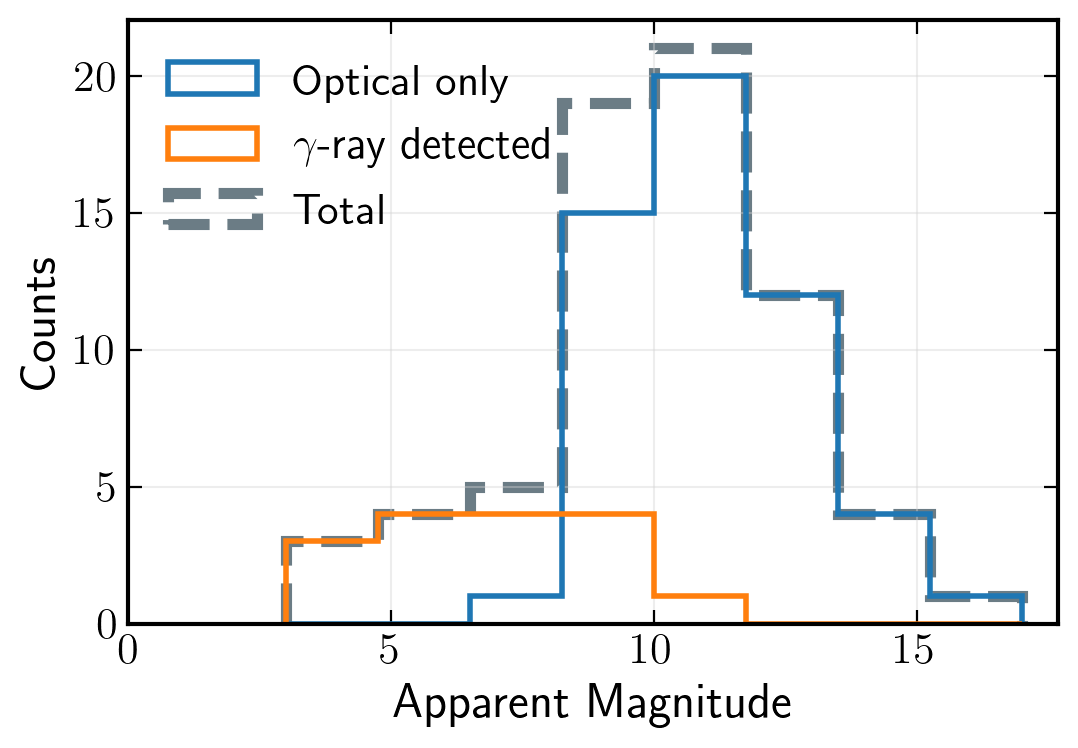

In [84]:
fig, ax = plt.subplots(dpi=200)

mag_bins = np.linspace(3., 17., 9)

plt.hist(df['Peak'][~df['gamma']],
         bins=mag_bins, histtype='step', lw=2., label='Optical only'
        )

plt.hist(df['Peak'][df['gamma']],
         bins=mag_bins, histtype='step', lw=2., label=r'$\gamma$-ray detected'
        )
                    
plt.hist(df['Peak'], lw=4., ls='--', color=sns.xkcd_rgb['battleship grey'],
        histtype='step', label='Total', bins=mag_bins, zorder=1)

plt.legend(loc=2, frameon=False)
plt.xlabel('Apparent Magnitude')
plt.ylabel('Counts')
plt.xlim(0, plt.xlim()[1])

plt.show()

## Source Confusion (question from Chris)

In [4]:
sys.path.append('/home/apizzuto/Nova/scripts/stacking/')
from source_config import get_sources

In [5]:
sources, name = get_sources(False, 'optical', 1.)

In [9]:
# df = pd.read_pickle('../master_nova_dataframe_with_duplicates.pkl')
df = pd.read_pickle('../master_nova_dataframe.pkl')

In [10]:
df.head()

,index,Name,Date,Peak,RA,Dec,gamma,gamma_start,gamma_stop,gamma_norm,gamma_ind,gamma_cutoff,refs,gamma_lim
0,1,V1369 Cen,2013-12-06 07:12:00.000,3.3,208.689012,-59.151158,True,56634.0,56672.0,2.51,2.00,2.0,xray:2EliasAnna,NaN
1,2,V5857 Sgr,2018-04-10 00:00:00.000,10.8,271.039375,-18.065500,False,NaN,NaN,NaN,NaN,NaN,optical: AAVSO,NaN
2,5,V5593 Sgr,2012-07-23 00:00:00.000,11.0,274.902831,-19.122878,False,NaN,NaN,NaN,NaN,NaN,Anna,1.0
3,7,V339 Del,2013-08-16 12:00:00.000,4.5,305.877860,20.767716,True,56520.0,56547.0,1.45,1.68,3.0,xray:1EliasAnna,NaN
4,8,V5666 Sgr,2014-01-26 00:00:00.000,8.7,276.287897,-22.605362,False,NaN,NaN,NaN,NaN,NaN,Anna,0.8


index                                   38
Name                              V611 Sct
Date               2016-09-07 00:00:00.000
Peak                                  13.4
RA                              276.374458
Dec                              -9.792306
gamma                                False
gamma_start                            NaN
gamma_stop                             NaN
gamma_norm                             NaN
gamma_ind                              NaN
gamma_cutoff                           NaN
refs            optical: ASASSN-transients
gamma_lim                              NaN
Name: 24, dtype: object          Name                     Date          RA        Dec
65  V1659 Sco  2016-09-07 00:00:00.000  265.740333 -33.428583


index                                  113
Name                             V1659 Sco
Date               2016-09-07 00:00:00.000
Peak                                  12.3
RA                              265.740333
Dec                             -

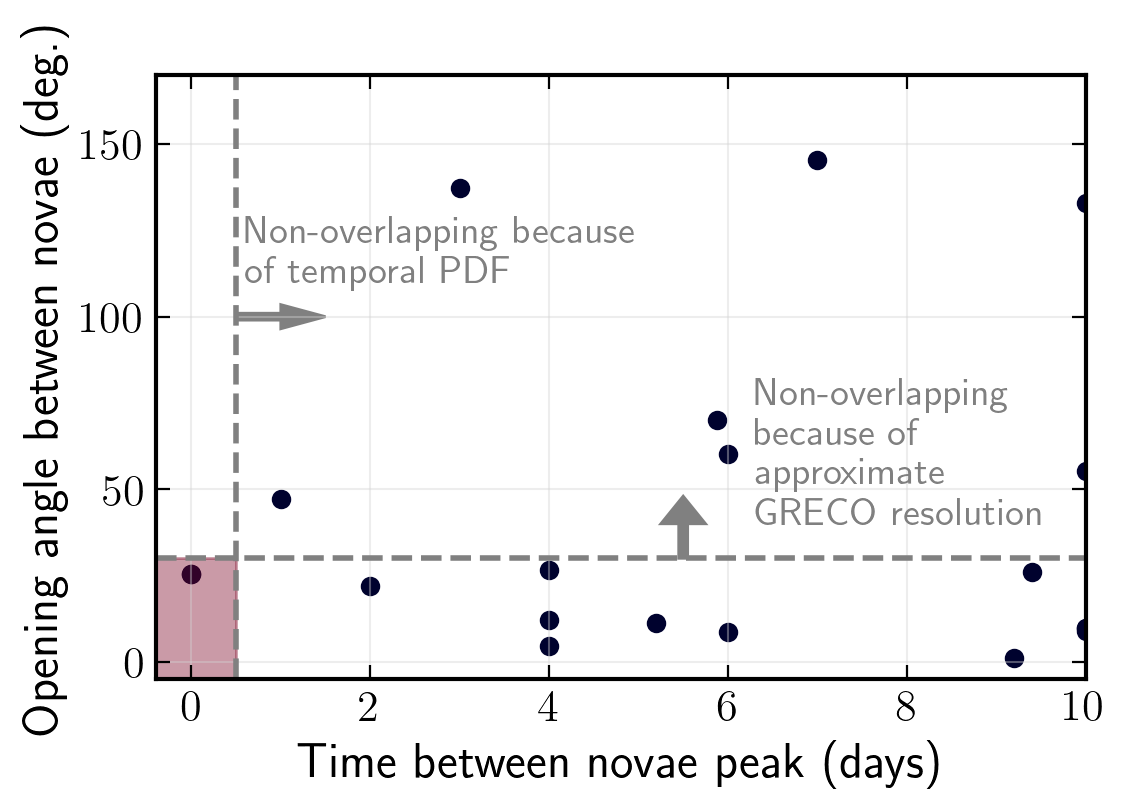

In [14]:
fig, ax = plt.subplots(dpi=200)

for i, nova in df.iterrows():
    msk = df['Name'] != nova['Name']
    t_offset = np.asarray([x.mjd - nova['Date'].mjd for x in df['Date']])
    msk *= (t_offset < 100.) * (t_offset >= 0.)
    close_nova = df[msk]
    if len(close_nova) > 0:
        if len(close_nova) == 1:
            opening_angle = np.atleast_1d(hp.rotator.angdist(
                [nova['RA'], nova['Dec']],
                [close_nova['RA'].values[0], 
                 close_nova['Dec'].values[0]],
                lonlat=True))
        else:
            opening_angle = hp.rotator.angdist(
                [np.asarray([nova['RA']]*len(close_nova)), 
                 np.asarray([nova['Dec']]*len(close_nova))],
                [close_nova['RA'].values, 
                 close_nova['Dec'].values],
                lonlat=True)
        plt.scatter(t_offset[msk], np.degrees(opening_angle), color=sns.xkcd_rgb['dark navy blue'])
        new_msk = (t_offset[msk] < 1) * (t_offset[msk] >= 0.)
        new_msk *= np.degrees(opening_angle) < 100.
        if len(close_nova[new_msk]) > 0:
            new_msk = (t_offset[msk] < 2) * (np.degrees(opening_angle) < 100.)
            print(nova, close_nova[new_msk][['Name', 'Date', 'RA', 'Dec']])
            print('\n')
# plt.xscale('log')
plt.arrow(0.5, 100., 0.5, 0., color='grey', width=2, head_width=7., head_length=0.5)
plt.axvline(0.5, color='grey', ls='dashed', lw=2.)
plt.text(0.6, 110., 'Non-overlapping because\n of temporal PDF', color='grey', fontsize=14)

plt.arrow(5.5, 30., 0.0, 10., color='grey', width=0.1, head_width=0.5, head_length=8.)
plt.axhline(30., color='grey', ls='dashed', lw=2.)
plt.text(6.3, 40., 'Non-overlapping \n because of \n approximate \n GRECO resolution', color='grey', fontsize=14)

plt.fill_between([-3., 0.5], [-60., -60.], [30., 30.], color=sns.xkcd_rgb['wine red'], alpha=0.4)

plt.xlim(-0.4, 10)
plt.xlabel('Time between novae peak (days)')
plt.ylabel('Opening angle between novae (deg.)')
plt.ylim(-5, 170)

plt.savefig('./duplicate_novae_greco.png', bbox_inches='tight')

plt.show()

In [12]:
sources[sources['mjd']==57637.5].weight

array([3.57288605e-05, 9.84054532e-05])

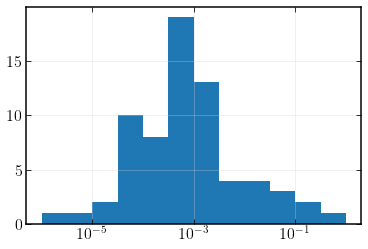

In [13]:
plt.hist(sources.weight, bins=np.logspace(-6., 0., 13), histtype='stepfilled')
plt.xscale('log')

70

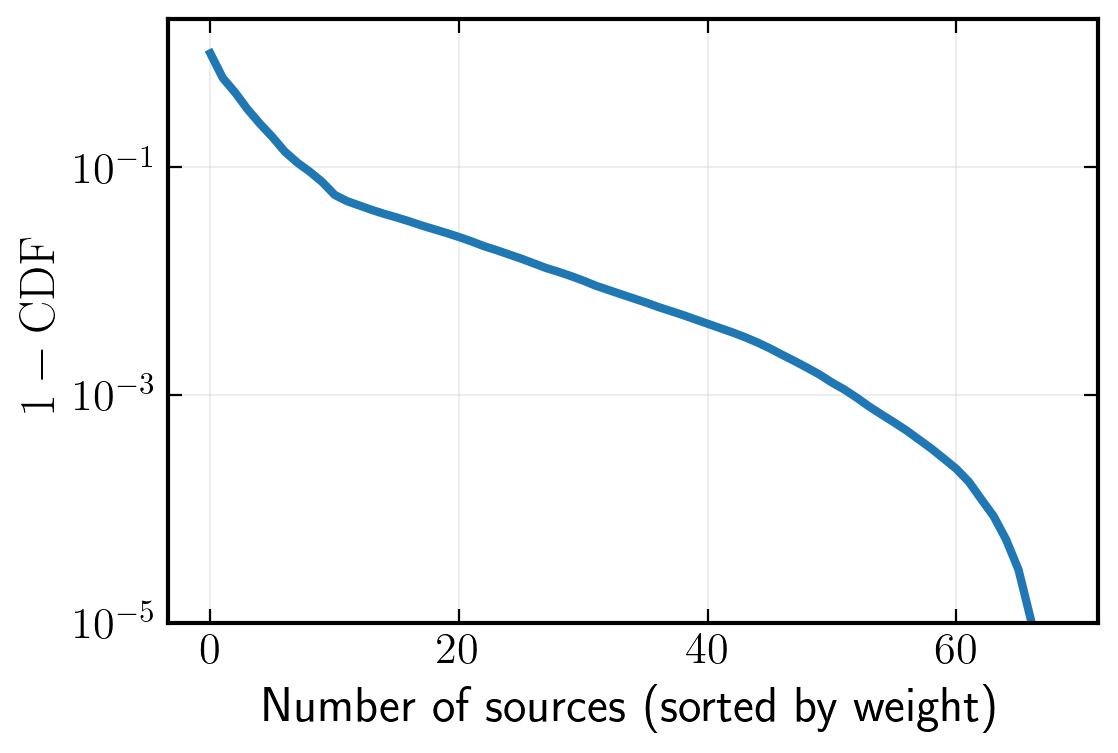

In [12]:
fig = plt.figure(dpi=200)

weights_sorted = np.sort(sources.weight)
cdf = np.append([0.0], np.cumsum(weights_sorted[::-1]))

plt.plot(1. - cdf, linewidth=3.)

plt.yscale('log')
plt.xlabel('Number of sources (sorted by weight)')
plt.ylabel(r'$1 - \mathrm{CDF}$')
plt.ylim(1e-5, 2e0)
plt.savefig('./greco_novae_source_stacking_weights_optical_cdf.png', bbox_inches='tight')
plt.show()

In [ ]:
np.count_nonzero(t_offset[msk] < 2) > 0 and np.count_nonzero(np.degrees(opening_angle) < 100) > 0

In [88]:
df

,index,Name,Date,Peak,RA,Dec,gamma,gamma_start,gamma_stop,gamma_norm,gamma_ind,gamma_cutoff,refs,gamma_lim
0,0,V613 Sct,2018-07-01 00:00:00.000,10.40,277.345667,-14.512222,False,NaN,NaN,NaN,NaN,NaN,optical: AAVSO,NaN
1,1,V569 Vul,2019-08-18 00:00:00.000,16.30,298.034375,27.705800,False,NaN,NaN,NaN,NaN,NaN,optical: Atel13068,NaN
2,2,OGLE-2013-NOVA-04,2013-04-14 00:00:00.000,13.00,270.342329,-25.313030,False,NaN,NaN,NaN,NaN,NaN,Anna,1.2
3,4,V392 Per,2018-04-29 12:00:00.000,6.20,70.839040,47.357186,True,58238.0,58246.0,8.90,1.90,inf,"xray:10,11Elias",NaN
4,8,V435 CMa,2018-04-07 00:00:00.000,12.10,108.441012,-21.208689,False,NaN,NaN,NaN,NaN,NaN,optical: AAVSO,NaN
5,9,V1658 Sco,2015-04-03 00:00:00.000,12.70,267.053250,-32.587067,False,NaN,NaN,NaN,NaN,NaN,optical: 1606.02755,NaN
6,11,V6566 Sgr,2020-01-30 00:00:00.000,11.03,269.058500,-20.716167,False,NaN,NaN,NaN,NaN,NaN,optical: AAVSO,NaN
7,13,OGLE-2012-NOVA-01,2012-05-05 00:00:00.000,12.50,269.204590,-27.229016,False,NaN,NaN,NaN,NaN,NaN,Anna,1.7
8,15,V556 Ser,2013-11-24 00:00:00.000,11.70,272.263902,-11.213992,False,NaN,NaN,NaN,NaN,NaN,Anna,0.8
9,16,V1706 Sco,2019-05-14 00:00:00.000,13.00,256.892417,-36.139667,False,NaN,NaN,NaN,NaN,NaN,optical: ASASSN-transients,NaN


In [87]:
pd.set_option('display.max_rows', 100)

In [5]:
gamma_novae = df[df['gamma']]
for nov in gamma_novae.iter

,index,Name,Date,Peak,RA,Dec,gamma,gamma_start,gamma_stop,gamma_norm,gamma_ind,gamma_cutoff,refs,gamma_lim
0,0,V613 Sct,2018-07-01 00:00:00.000,10.4,277.345667,-14.512222,False,NaN,NaN,NaN,NaN,NaN,optical: AAVSO,NaN
1,1,V569 Vul,2019-08-18 00:00:00.000,16.3,298.034375,27.705800,False,NaN,NaN,NaN,NaN,NaN,optical: Atel13068,NaN
2,2,OGLE-2013-NOVA-04,2013-04-14 00:00:00.000,13.0,270.342329,-25.313030,False,NaN,NaN,NaN,NaN,NaN,Anna,1.2
3,4,V392 Per,2018-04-29 12:00:00.000,6.2,70.839040,47.357186,True,58238.0,58246.0,8.9,1.90,inf,"xray:10,11Elias",NaN
4,8,V435 CMa,2018-04-07 00:00:00.000,12.1,108.441012,-21.208689,False,NaN,NaN,NaN,NaN,NaN,optical: AAVSO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,111,V2860 Ori,2019-08-08 00:00:00.000,9.4,92.489387,12.206986,False,NaN,NaN,NaN,NaN,NaN,optical: AAVSO,NaN
65,112,V5856 Sgr,2016-11-09 00:00:00.000,5.4,275.217710,-28.370030,True,57700.0,57715.0,5.4,1.86,5.9,xray:5Elias,NaN
66,113,V5667 Sgr,2015-02-25 00:00:00.000,9.0,273.600082,-25.911846,False,NaN,NaN,NaN,NaN,NaN,Anna,0.6
67,115,V3666 Oph,2018-08-11 00:00:00.000,9.0,265.600375,-20.885750,False,NaN,NaN,NaN,NaN,NaN,optical: AAVSO,NaN


In [24]:
from importlib import reload
import plotting

In [25]:
new_plots = plotting.SynthesisPlots()

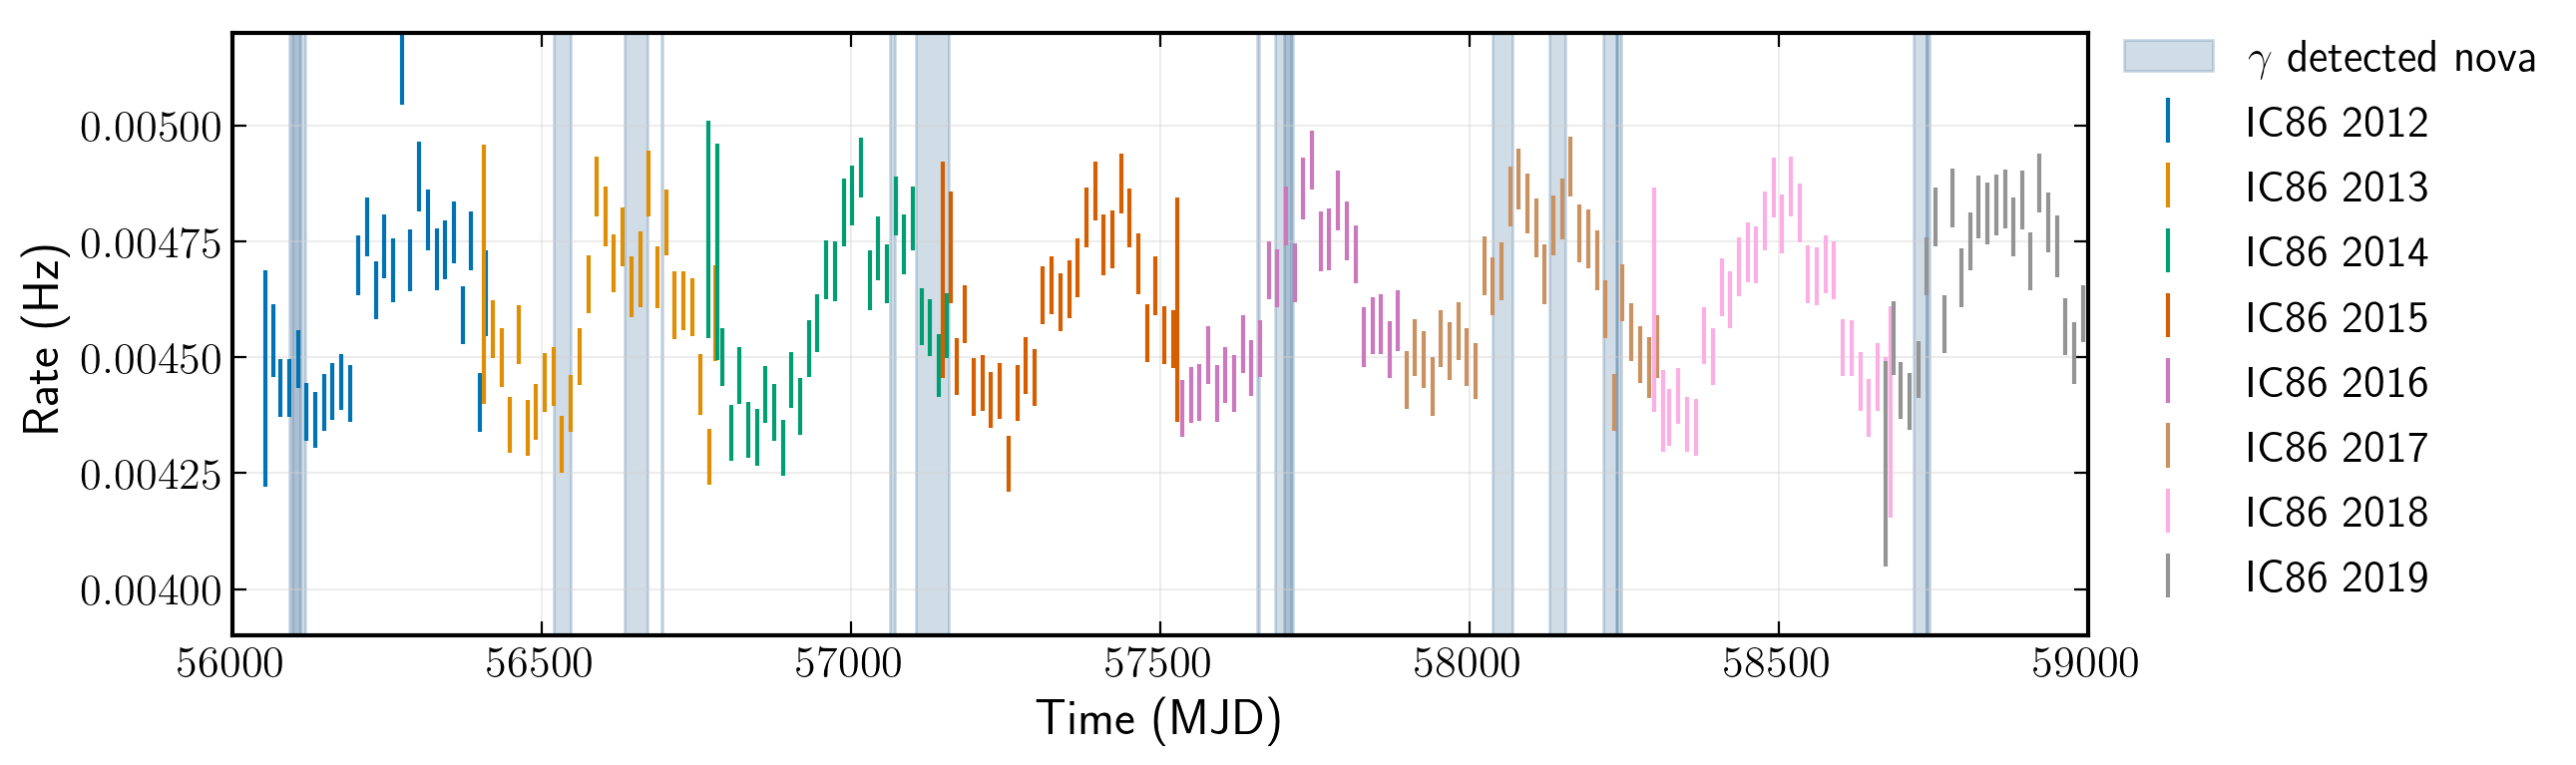

In [26]:
new_plots.gamma_lightcurve_with_greco_rate()

In [33]:
gamma_df = df[df['gamma']]
gamma_df.sort_values('gamma_start')

,index,Name,Date,Peak,RA,Dec,gamma,gamma_start,gamma_stop,gamma_norm,gamma_ind,gamma_cutoff,refs,gamma_lim
50,86,V1324 Sco,2012-06-21 19:12:00.000,9.80,267.724625,-32.622525,True,56093.0,56110.0,4.40,1.92,7.7,xray:1EliasAnna,NaN
42,72,V959 Mon,2016-06-19 00:00:00.000,5.00,99.911420,5.897780,True,56097.0,56119.0,2.64,1.50,1.3,xray:1EliasAnna,NaN
23,38,V339 Del,2013-08-16 12:00:00.000,4.50,305.877860,20.767716,True,56520.0,56547.0,1.45,1.68,3.0,xray:1EliasAnna,NaN
41,71,V1369 Cen,2013-12-06 07:12:00.000,3.30,208.689012,-59.151158,True,56634.0,56672.0,2.51,2.00,2.0,xray:2EliasAnna,NaN
60,101,V745 Sco,2014-02-06 00:00:00.000,8.70,268.842614,-33.249600,True,56694.0,56695.0,3.00,2.20,inf,AnnaAnna,NaN
58,99,V1535 Sco,2015-02-11 00:00:00.000,8.20,255.859044,-35.071616,True,57063.99997,57070.99997,1.00,2.30,inf,AnnaAnna,NaN
62,105,V5668 Sgr,2015-03-21 00:00:00.000,4.30,279.237500,-28.928330,True,57105.0,57158.0,0.61,2.11,inf,xray:2EliasAnna,NaN
40,68,V407 Lup,2019-09-25 09:36:00.000,5.60,232.257580,-44.828000,True,57657.0,57660.0,1.80,2.20,inf,"xray:3, This workElias",NaN
20,35,V5855 Sgr,2016-10-24 19:12:00.000,9.80,272.617880,-27.499700,True,57686.0,57712.0,2.96,2.26,inf,xray:4Elias,NaN
65,112,V5856 Sgr,2016-11-09 00:00:00.000,5.40,275.217710,-28.370030,True,57700.0,57715.0,5.40,1.86,5.9,xray:5Elias,NaN


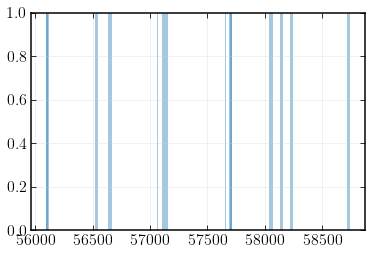

In [32]:
for i, nov in df[df['gamma']].iterrows():
    plt.axvspan(nov['gamma_start'].value, nov['gamma_stop'].value, alpha=0.4)

In [15]:
gamma_df = df[df['gamma']]
gamma_df.sort_values('gamma_start')

msk = np.asarray([name in ['V5855 Sgr', 'V5856 Sgr'] for name in gamma_df['Name']])
nearby = gamma_df[msk]
nearby[['Name', 'RA', 'Dec', 'gamma_start', 'gamma_stop']]

,Name,RA,Dec,gamma_start,gamma_stop
20,V5855 Sgr,272.61788,-27.49970,57686.0,57712.0
65,V5856 Sgr,275.21771,-28.37003,57700.0,57715.0


In [13]:
msk = np.asarray([name in ['V5855 Sgr', 'V5856 Sgr'] for name in gamma_df['Name']])

[False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True]